In [39]:
import numpy as np
import pandas as pd
from pylab import *
from sympy import Symbol,expand
%config InlineBackend.figure_formats = ['svg']

x=Symbol('x')

In [40]:
def LSQ_polyfit( NP, XL, XC_fun, XC_der ):
  
    ########################################################
    # LINEAR LEAST SQUARES PROBLEM
    #
    ( xl, yl ) = XL

    # Vandermonde matrix
    X = xl[:, None] ** np.arange( NP, -1, -1 )

    XTX = X.transpose().dot( X )
    XTy = X.transpose().dot( yl )

    # NO CONSTRAINTS IMPOSED => standard LSQ solution
    if XC_fun == None and XC_der == None:
      AA = XTX
      bb = XTy
      return np.linalg.solve( AA, bb )

    ########################################################
    # LAGRANGE MULTIPLIERS FOR CONSTRAINTS
    #
    if XC_fun != None:
      ( xc_fun, yc_fun ) = XC_fun 

      # function constraints
      xF = np.array( xc_fun ) 
      bF = np.array( yc_fun ) 

      # Vandermonde matrix
      AF = xF[:, None] ** np.arange( NP, -1, -1 )

    if XC_der != None:
      ( xc_der, yc_der ) = XC_der

      # derivative constraints
      xD = np.array( xc_der )
      bD = np.array( yc_der ) 

      # Derivative of the Vandermonde matrix
      AD = np.array( [  (i*xD**(i-1) if i > 0 else 0*xD) \
                        for i in range(NP,-1,-1) ] ).T

    if XC_fun != None and XC_der != None:
      Ac = np.block( [ [AF], [AD] ] )
      bc = np.block( [ bF, bD ] )
    elif XC_fun != None:
      Ac = AF
      bc = bF
    elif XC_der != None:
      Ac = AD
      bc = bD
      
    AcT = Ac.transpose()
    Z0 = np.zeros( ( Ac.shape[0], Ac.shape[0] ) )

    ########################################################
    # ASSEMBLE AND SOLVE GLOBAL SYSTEM
    #
    AA = np.block( [ [ XTX, AcT ], [ Ac, Z0 ] ] )
    bb = np.block( [ XTy, bc ] )
      
    alambda = np.linalg.solve( AA, bb )

    # final polynomial coeffs without lambdas
    return alambda[ 0:NP+1 ]

In [41]:
dfc = pd.read_excel( 'Generator_Data_Elisabeta.xlsx', 'Sheet1' )
Load = np.array( dfc['Load'] )
Eff = np.array( dfc['Eff'] )

Load = np.array( Load[~np.isnan(Load)] )
Eff = np.array( Eff[~np.isnan(Eff)] )

In [42]:
Load_1 = Load[:6]
Load_2 = Load[5:]
Eff_1  = Eff[:6]
Eff_2  = Eff[5:]

-6714.48631*x**4 + 2591.59775*x**3 - 380.83406*x**2 + 27.04232*x + 0.00329

-1.16857*x**4 + 3.31173*x**3 - 3.44296*x**2 + 1.5416*x + 0.71041

(0.125423729,
 array([-6.71448631e+03,  2.59159775e+03, -3.80834059e+02,  2.70423225e+01,
         3.29394948e-03]),
 array([-1.16856952,  3.31172525, -3.44296217,  1.5416029 ,  0.71040716]))

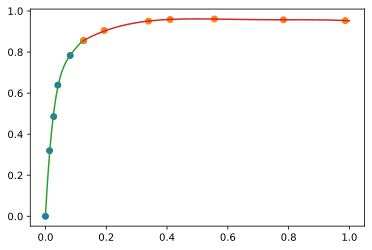

In [47]:
plt.plot( Load_1, Eff_1, 'o' )
plt.plot( Load_2, Eff_2, 'o' )

poly_C1 = LSQ_polyfit( 4, ( Load_1, Eff_1 ), ([Load_1[-1]],[Eff_1[-1]]), None )
Load_1_plt = np.linspace( Load_1[0], Load_1[-1], 100 )
Eff_1_plt = np.polyval( poly_C1, Load_1_plt )
plot( Load_1_plt, Eff_1_plt, '-' )

# impose derivative at curved common point
poly_C1_der = np.poly1d( poly_C1 ).deriv()
der1 = poly_C1_der(Load_2[0])

poly_C2 = LSQ_polyfit( 4, ( Load_2, Eff_2 ), ([Load_2[0]],[Eff_2[0]]), ([Load_2[0]],[der1]) )
Load_2_plt = np.linspace( Load_2[0], 1.0, 100 )
Eff_2_plt = np.polyval( poly_C2, Load_2_plt )
plot( Load_2_plt, Eff_2_plt, '-' )

display( expand(np.poly1d( np.round( poly_C1, 5 ) )(x)) )
display( expand(np.poly1d( np.round( poly_C2, 5 ) )(x)) )
Load_2[0], poly_C1, poly_C2

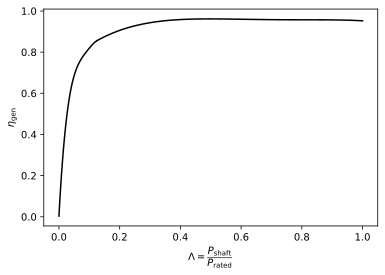

In [36]:
plot( Load_1_plt, Eff_1_plt, 'k-' )
plot( Load_2_plt, Eff_2_plt, 'k-' )
plt.xlabel( '$\\Lambda = \\dfrac{P_\\mathrm{shaft}}{P_\\mathrm{rated}}$');
plt.ylabel( '$\\eta_\\mathrm{gen}$')
plt.savefig( 'GenertorEff_plot.pdf' )
plt.savefig( 'GenertorEff_plot.svg' )  